# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day. This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

In this project we'll try to predict the total number of bikes people rented in a given hour. The column `cnt` is our target variable. We'll create a few different machine learning models and evaluate their performance.

In [1]:
import pandas as pd

bike_rentals = pd.read_csv('bike_rentals.csv')

In [63]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

## Exploring the Data set

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Let's make a histogram of the `cnt` column of `bike_rentals`, and take a look at the distribution of total rentals.

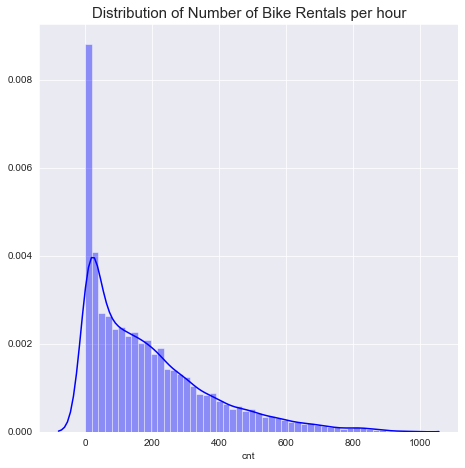

In [4]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(7.5, 7.5))
ax = sns.distplot(bike_rentals['cnt'], color='b')
ax.set_title('Distribution of Number of Bike Rentals per hour', size=15)
plt.show()

The distribution of Number of Bike Rentals per hour is **right skewed (postively skewed)**, although majority of the distributions are **normal**, it's only natural for this distribution to be skewed as we can expect very low rentals in the late and early hours of day.

Let's drop `casual` and `registered` columns as they 'leak' data about the number of rentals.

In [5]:
bike_rentals.drop(columns=['casual', 'registered'], inplace=True)

## Feature Selection & Engineering

The `hr` column in `bike_rentals` contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [6]:
def assign_label(i):
    if i < 6:
        return 4
    else:
        return i//6
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,4


Further let's explore how each column is correlated with `cnt`. Here we make use of the **Spearman Rank Correlation Coefficient (SRCC)** instead of  PCC as of one the limitations of **Pearson Correlation Coefficient (PCC)**(the default correlation metric) is that it requires both variables to be normally distributed. As we saw earlier, our target variable `cnt` has a *right skewed distribution*.

In [7]:
corr_cnt = bike_rentals.corr(method='spearman')['cnt']
corr_cnt = np.absolute(corr_cnt)
corr_cnt

instant       0.243742
season        0.185179
yr            0.207500
mnth          0.125889
hr            0.510878
holiday       0.029526
weekday       0.030297
workingday    0.021033
weathersit    0.126276
temp          0.423330
atemp         0.423258
hum           0.359614
windspeed     0.126629
cnt           1.000000
time_label    0.504020
Name: cnt, dtype: float64

## Linear Regression

Let's select features with a correlation coefficient higher than 0.35 to be used for Linear Regression.

In [8]:
lin_reg_ft = list(corr_cnt[corr_cnt > 0.35].index)
lin_reg_ft

['hr', 'temp', 'atemp', 'hum', 'cnt', 'time_label']

We will remove `temp`, as the variable `atemp`, short for 'Adjusted Temperature' is a better estimate of the temperature as it takes into account various factors which can cause erroneous readings.

In [9]:
lin_reg_ft.remove('cnt')
lin_reg_ft.remove('temp')
lin_reg_ft

['hr', 'atemp', 'hum', 'time_label']

In [10]:
bike_rentals[lin_reg_ft]

,hr,atemp,hum,time_label
0,0,0.2879,0.81,4
1,1,0.2727,0.80,4
2,2,0.2727,0.80,4
3,3,0.2879,0.75,4
4,4,0.2879,0.75,4
...,...,...,...,...
17374,19,0.2576,0.60,3
17375,20,0.2576,0.60,3
17376,21,0.2576,0.60,3
17377,22,0.2727,0.56,3


### Splitting the Data into Train and Test sets

Before we can begin applying machine learning algorithms, we will need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting.

The error metrics which we will use are Mean Square Error (MSE) and Root Mean Squared Error (RMSE).

Let's split the dataframe in two:
- `train`- Containing 80% of the rows from the original dataframe.
- `test` - Containing the remaining 20%.

In [11]:
train = bike_rentals.sample(frac=0.8, replace=True, random_state=1)
test_index = ~bike_rentals.index.isin(train)
test = bike_rentals[test_index]

Applying the Linear Regression model

In [12]:
# Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(train[lin_reg_ft], train['cnt'])

# Predicting
predictn_test = lin_model.predict(test[lin_reg_ft])
predictn_train = lin_model.predict(train[lin_reg_ft])

# Performance Evaluation
mse_test = mean_squared_error(test['cnt'], predictn_test)
mse_train = mean_squared_error(train['cnt'], predictn_train)
rmse_test = np.sqrt(mse_test)
rmse_train = np.sqrt(mse_train)

print('RMSE - test:', rmse_test)
print('RMSE - train:', rmse_train)

RMSE - test: 140.1356547427116
RMSE - train: 137.57167224279604


We got unexpectedly high error values, this might be because of a few very high error values (outliers). Let's visualize the error distribution to get a better insight.

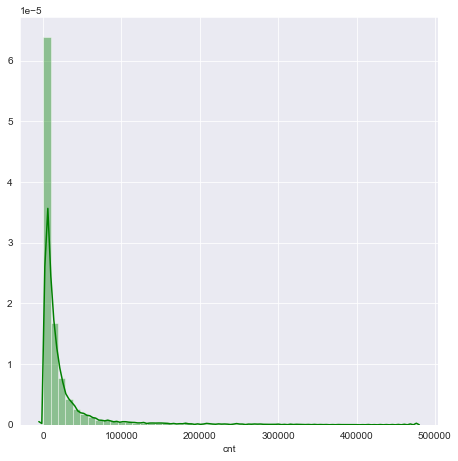

In [13]:
sq_error = (test['cnt']-predictn_test)**2
fg, axs = plt.subplots(figsize=(7.5, 7.5))
axs = sns.distplot(sq_error, color='g')

We were right about the error distribution. Nevertheless Linear Regression will not give us low error values as the relationship between majority of the features and our target variable doesn't seem to be a linear one. Let's use an algorithm which can better capture non-linear relationships between variables. 

Next we'll train a model using the **Decision Trees (ID3 Algorithm)**.

## Decision Trees

Now we are ready to apply the decision tree algorithm. We will be able to compare its error with the error from linear regression, which will enable us to pick the better algorithm for this data set.

In [14]:
# Preparing features.
features = list(bike_rentals.columns)
features.remove('instant')
features.remove('cnt')
features.remove('dteday')
features.remove('temp')

We'll remove `dteday` as it's a datetime object and cannot be used. We'll also remove the `instant` column as it gives the index number which is not useful in predicting `cnt`. 

In [21]:
# Decision Tree Model
tree_model = DecisionTreeRegressor(min_samples_leaf=3)
tree_model.fit(train[features], train['cnt'])

# Predicting
tree_predictn_test = tree_model.predict(test[features])
tree_predictn_train = tree_model.predict(train[features])

# Performance Evaluation
tree_mse_test = mean_squared_error(test['cnt'], tree_predictn_test)
tree_mse_train = mean_squared_error(train['cnt'], tree_predictn_train)
tree_rmse_test = np.sqrt(tree_mse_test)
tree_rmse_train = np.sqrt(tree_mse_train)

print('RMSE - test:', tree_rmse_test)
print('RMSE - train:', tree_rmse_train)

RMSE - test: 43.46844806886701
RMSE - train: 21.632639956639125


Although we got a much lower error value, our model overfitted, it gave us very different error values on both the sets. Decision Trees often overfit when they have too much depth and make overly complex rules that match the training data but aren't able to generalize well to new data.

Three ways to combat overfitting:
- Use ensampling to blend the predictions of many trees.
- Restrict the depth of the tree while we're building it.

The random forest algorithm is a popular choice for doing this.

## Random Forests

Let's apply the Random Forest Algorithm to further improve our accuracy. 

In [85]:
# Random Forest Model
forest_model = RandomForestRegressor(n_estimators=250, max_features='auto', min_samples_leaf=1, min_samples_split=2, max_depth=24)
forest_model.fit(train[features], train['cnt'])

# Predicting
forest_predictn_test = forest_model.predict(test[features])
forest_predictn_train = forest_model.predict(train[features])

# Performance Evaluation
forest_mse_test = mean_squared_error(test['cnt'], forest_predictn_test)
forest_mse_train = mean_squared_error(train['cnt'], forest_predictn_train)
forest_rmse_test = np.sqrt(forest_mse_test)
forest_rmse_train = np.sqrt(forest_mse_train)

print('RMSE - test:', forest_rmse_test)
print('RMSE - train:', forest_rmse_train)

RMSE - test: 32.574700210922835
RMSE - train: 11.82647638802071


It's clear that the Random Forest Regressor have least RMSE values. 

Hyperparameter tuning can further improve the performance of our Random Forest. To accomplish that we can perform a **Grid Search** operation or **Random Search** operation. Both these processes are computationally heavy tasks and require a careful selection of hyperparamter values. 